# 04__activities
# analyzing activity levels per element (neg ctrls; between biotypes)

in this notebook, i perform analyses examining the activities of reference tiles in both pool1 and pool2. i compare reference sequences to negative controls, examine reference activities between biotypes, examine how MPRA activity compares to CAGE expression, and determine how many sequences are expressed across cell types.

------

figures in this notebook:
- **Fig 1C, Fig S4A, Fig S8**: boxplots comparing reference sequences to negative controls
- **Fig 1D, Fig S4B**: boxplots comparing activities between biotypes
- **Fig 1E**: KDE plot comparing CAGE cell type specificity and MPRA cell type specificity
- **Fig 1F**: barplot showing % of reference sequences active in 1 or all 3 cell types

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import time

from itertools import chain
from decimal import Decimal
from scipy import stats
from statsmodels.sandbox.stats import multicomp

# import utils
sys.path.append("../../utils")
from plotting_utils import *
from misc_utils import *
from norm_utils import *

%matplotlib inline

In [2]:
sns.set(**PAPER_PRESET)
fontsize = PAPER_FONTSIZE

## variables

In [3]:
activ_dir = "../../data/02__activs"
pval_dir = "../../data/03__pvals"
index_dir = "../../data/00__index"

In [4]:
pool1_hela_barc_activ_f = "POOL1__pMPRA1__HeLa__activities_per_barcode.txt"
pool1_hepg2_barc_activ_f = "POOL1__pMPRA1__HepG2__activities_per_barcode.txt"
pool1_k562_barc_activ_f = "POOL1__pMPRA1__K562__activities_per_barcode.txt"

pool1_hela_elem_activ_f = "POOL1__pMPRA1__HeLa__activities_per_element.txt"
pool1_hepg2_elem_activ_f = "POOL1__pMPRA1__HepG2__activities_per_element.txt"
pool1_k562_elem_activ_f = "POOL1__pMPRA1__K562__activities_per_element.txt"

pool1_hela_pvals_f = "POOL1__pMPRA1__HeLa__pvals.txt"
pool1_hepg2_pvals_f = "POOL1__pMPRA1__HepG2__pvals.txt"
pool1_k562_pvals_f = "POOL1__pMPRA1__K562__pvals.txt"

In [5]:
pool1_nocmv_hela_barc_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_barcode.txt"
pool1_nocmv_hepg2_barc_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_barcode.txt"
pool1_nocmv_k562_barc_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_barcode.txt"

pool1_nocmv_hela_elem_activ_f = "POOL1__pNoCMVMPRA1__HeLa__activities_per_element.txt"
pool1_nocmv_hepg2_elem_activ_f = "POOL1__pNoCMVMPRA1__HepG2__activities_per_element.txt"
pool1_nocmv_k562_elem_activ_f = "POOL1__pNoCMVMPRA1__K562__activities_per_element.txt"

pool1_nocmv_hela_pvals_f = "POOL1__pNoCMVMPRA1__HeLa__pvals.txt"
pool1_nocmv_hepg2_pvals_f = "POOL1__pNoCMVMPRA1__HepG2__pvals.txt"
pool1_nocmv_k562_pvals_f = "POOL1__pNoCMVMPRA1__K562__pvals.txt"

In [6]:
pool2_hepg2_barc_activ_f = "POOL2__pMPRA1__HepG2__activities_per_barcode.txt"
pool2_k562_barc_activ_f = "POOL2__pMPRA1__K562__activities_per_barcode.txt"

pool2_hepg2_elem_activ_f = "POOL2__pMPRA1__HepG2__activities_per_element.txt"
pool2_k562_elem_activ_f = "POOL2__pMPRA1__K562__activities_per_element.txt"

pool2_hepg2_pvals_f = "POOL2__pMPRA1__HepG2__pvals.txt"
pool2_k562_pvals_f = "POOL2__pMPRA1__K562__pvals.txt"

In [7]:
pool1_index_f = "%s/tss_oligo_pool.index.txt" % index_dir
pool2_index_f = "%s/dels_oligo_pool.index.txt" % index_dir

In [8]:
annot_f = "../../misc/00__tss_properties/mpra_id_to_biotype_map.txt"
id_map_f = "../../misc/00__tss_properties/mpra_tss_detailed_info.txt"
sel_map_f = "../../misc/00__tss_properties/mpra_tss_selection_info.txt"

## 1. import data

In [9]:
pool1_index = pd.read_table(pool1_index_f, sep="\t")
pool2_index = pd.read_table(pool2_index_f, sep="\t")

In [10]:
pool1_index_elem = pool1_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]
pool2_index_elem = pool2_index[["element", "oligo_type", "unique_id", "dupe_info", "SNP"]]

pool1_index_elem = pool1_index_elem.drop_duplicates()
pool2_index_elem = pool2_index_elem.drop_duplicates()

In [11]:
annot = pd.read_table(annot_f, sep="\t")
annot.head()

,seqID,PromType2
0,WILDTYPE__Antisense.noflip.NA__chr1:100435456....,div_lnc
1,WILDTYPE__Lincrna.flip.sense__chr1:100731637.....,div_lnc
2,FLIPPED__Lincrna.flip.antisense__chr1:10073163...,div_lnc
3,FLIPPED__mrna.flip.antisense__chr1:100731714.....,div_pc
4,WILDTYPE__mrna.flip.sense__chr1:100731714..100...,div_pc


In [12]:
id_map = pd.read_table(id_map_f, sep="\t")
id_map.head()

,gene_id,TSS_associated_1st.transc_id,oligo_reg,TSS_id,TSS_description,TSS_transc_association,avExpALL,gene_name,gene_type,GeneType,...,rs.SNP1,rs.SNP2,R.squared,Distance,trait,n.eQTLs,n.eQTLs94,PromType,PromType2,PromType3
0,ENSG00000000419.8,ENST00000371583,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",p1@DPM1,"0bp_to_ENST00000371583,ENST00000413082,ENST000...",71.110566,DPM1,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
1,ENSG00000002586.13,ENST00000381187,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",p3@CD99,-14bp_to_ENST00000381187_5end,17.394880,CD99,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
2,ENSG00000002919.10,ENST00000359238,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",p2@SNX11,"0bp_to_ENST00000359238,ENST00000393405,ENST000...",4.722549,SNX11,protein_coding,protein_coding,...,rs72823592,rs16952265,0.844249196799263,-61879,Epilepsy_(generalized),2,2,protein_coding,protein_coding,protein_coding
3,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding
4,ENSG00000003436.10,ENST00000435414,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",p3@TFPI,0bp_to_ENST00000435414_5end,3.679946,TFPI,protein_coding,protein_coding,...,NaN,NaN,NaN,NaN,NaN,0,0,protein_coding,protein_coding,protein_coding


In [13]:
sel_map = pd.read_table(sel_map_f, sep="\t")
sel_map.head()

,oligo_reg,TSS_id,selected,PromType2
0,"chr20:49575034..49575148,-","chr20:49575059..49575077,-",mRNA.random,protein_coding
1,"chrX:2609217..2609331,+","chrX:2609278..2609302,+",mRNA.random,protein_coding
2,"chr17:46184858..46184972,+","chr17:46184920..46184951,+",mRNA.gwas,protein_coding
3,"chr2:188378345..188378459,-","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding
4,"chr2:188378345..188378459,+","chr2:188378374..188378387,-",mRNA.expmatch,protein_coding


### pool 1

In [14]:
pool1_hela_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_elem_activ_f), sep="\t")
pool1_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_elem_activ_f), sep="\t")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,-1.229482,-1.201427,-1.207830,-1.138838
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,-0.264065,-0.260860,-0.300284,-0.182098
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,-0.534859,-0.557712,-0.578824,-0.754250
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,-1.250940,-1.065514,-1.058389,-1.399819
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,0.180815,0.251183,0.186228,0.145362


In [15]:
pool1_hela_reps = [x for x in pool1_hela_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps = [x for x in pool1_hepg2_elem_norm.columns if "rna_" in x]
pool1_k562_reps = [x for x in pool1_k562_elem_norm.columns if "rna_" in x]
pool1_hepg2_reps

['rna_3',
 'rna_4',
 'rna_5',
 'rna_6',
 'rna_7',
 'rna_8',
 'rna_9',
 'rna_10',
 'rna_11',
 'rna_12',
 'rna_13',
 'rna_14']

In [16]:
pool1_hela_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hela_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_hepg2_barc_activ_f), sep="\t")
pool1_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool1_k562_barc_activ_f), sep="\t")
pool1_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,rna_11,rna_12,rna_13,rna_14
0,AAAACAAAGTC,-0.232915,-0.409743,-0.830252,-0.558582,0.259745,0.471566,0.137889,0.605610,-0.115982,0.389549,0.251261,0.360733
1,AAAACAAAGTT,-1.641943,-1.786002,NaN,NaN,NaN,-1.472057,-2.748240,0.123337,-3.569422,-0.959375,-2.188633,-1.877116
2,AAAACAAATGT,0.445553,0.331374,0.022147,-0.308519,0.782481,0.935864,0.411982,0.688970,0.972243,0.836551,0.892322,0.819801
3,AAAACAACGTC,-0.010666,1.834886,1.047326,-0.196539,0.456452,0.568126,0.930430,1.951003,0.654473,1.429290,2.026544,1.170410
4,AAAACAACGTG,0.339223,0.864835,-1.879958,-0.186074,0.235210,-1.084751,1.190649,1.043910,-1.136628,0.028256,0.408414,0.148594


In [17]:
pool1_hela_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hela_pvals_f), sep="\t")
pool1_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_hepg2_pvals_f), sep="\t")
pool1_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool1_k562_pvals_f), sep="\t")
pool1_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.403405,0.330523,0.485259,0.487744,0.419931,0.289986,0.127793,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,CONTROL_BUT_HAS_SNP,1.146015,0.949856,1.324285,1.245177,1.331950,1.112834,0.963992,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,CONTROL_BUT_HAS_SNP,0.654683,0.618780,0.782989,0.782589,0.857763,0.969354,0.618092,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,CONTROL_BUT_HAS_SNP,0.344792,0.375084,0.052049,0.452240,0.243133,0.199732,0.396825,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.574229,1.580879,1.730772,1.652956,1.637522,1.661432,1.461112,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [18]:
pool2_hepg2_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_elem_activ_f), sep="\t")
pool2_k562_elem_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_elem_activ_f), sep="\t")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183


In [19]:
pool2_hepg2_reps = [x for x in pool2_hepg2_elem_norm.columns if "rna_" in x]
pool2_k562_reps = [x for x in pool2_k562_elem_norm.columns if "rna_" in x]
pool2_hepg2_reps

['rna_3', 'rna_4', 'rna_5', 'rna_6', 'rna_7', 'rna_8', 'rna_9', 'rna_10']

In [20]:
pool2_hepg2_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_hepg2_barc_activ_f), sep="\t")
pool2_k562_barc_norm = pd.read_table("%s/%s" % (activ_dir, pool2_k562_barc_activ_f), sep="\t")
pool2_hepg2_barc_norm.head()

,barcode,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10
0,AAAACAAAGTC,NaN,NaN,0.559995,NaN,NaN,NaN,NaN,NaN
1,AAAACAACGTG,-1.780485,-0.598085,-1.170739,-0.878212,-1.162959,-1.45008,-0.133118,-1.089508
2,AAAACAACTGG,NaN,NaN,-2.425661,NaN,NaN,NaN,NaN,NaN
3,AAAACAAGATG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAAACAAGATT,-1.028853,-1.208253,-3.278023,NaN,-2.543835,-4.28303,-1.792000,-0.798199


In [21]:
pool2_hepg2_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_hepg2_pvals_f), sep="\t")
pool2_k562_pvals = pd.read_table("%s/%s" % (pval_dir, pool2_k562_pvals_f), sep="\t")
pool2_hepg2_pvals.head()

,unique_id,element,oligo_type,rna_3_log2fc,rna_4_log2fc,rna_5_log2fc,rna_6_log2fc,rna_7_log2fc,rna_8_log2fc,rna_9_log2fc,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_BUT_HAS_SNP,-0.740530,-0.483852,-0.266400,-0.420682,-0.565798,-0.276644,-0.338944,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,CONTROL_BUT_HAS_SNP,0.395869,0.428595,0.382347,0.279643,0.291139,0.361236,0.427300,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,CONTROL_BUT_HAS_SNP,-0.160006,-0.241741,-0.140360,-0.096893,-0.253929,-0.164211,-0.046484,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,CONTROL_BUT_HAS_SNP,1.519378,1.814816,1.483085,1.542379,1.720079,1.566608,1.711800,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,CONTROL_SNP_INDIV,-0.652900,-0.634970,-0.355650,-0.403086,-0.509460,-0.427165,-0.256770,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 2. merge with index

### pool 1

In [22]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_index_elem, on=["unique_id", "element"], how="left")

In [23]:
pool1_hela_barc_norm = pool1_hela_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_hepg2_barc_norm = pool1_hepg2_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")
pool1_k562_barc_norm = pool1_k562_barc_norm.merge(pool1_index, left_on="barcode", right_on="barcode", how="left")

In [24]:
pool1_hela_elem_norm["better_type"] = pool1_hela_elem_norm.apply(better_type, axis=1)
pool1_hepg2_elem_norm["better_type"] = pool1_hepg2_elem_norm.apply(better_type, axis=1)
pool1_k562_elem_norm["better_type"] = pool1_k562_elem_norm.apply(better_type, axis=1)

In [25]:
pool1_hela_elem_norm = pool1_hela_elem_norm.merge(pool1_hela_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm = pool1_hepg2_elem_norm.merge(pool1_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_k562_elem_norm = pool1_k562_elem_norm.merge(pool1_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool1_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_10_padj,rna_11_padj,rna_12_padj,rna_13_padj,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.043711e-04,4.644729e-17,3.492436e-17,1.681772e-17,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,3.011102e-07,2.598576e-07,4.289247e-11,2.666966e-08,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,5.031197e-27,3.273184e-31,5.153033e-31,7.265345e-30,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active


### pool 2

In [26]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_index_elem, on=["unique_id", "element"], how="left")

In [27]:
pool2_hepg2_barc_norm = pool2_hepg2_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")
pool2_k562_barc_norm = pool2_k562_barc_norm.merge(pool2_index, left_on="barcode", right_on="barcode", how="left")

In [28]:
pool2_hepg2_elem_norm["better_type"] = pool2_hepg2_elem_norm.apply(better_type, axis=1)
pool2_k562_elem_norm["better_type"] = pool2_k562_elem_norm.apply(better_type, axis=1)

In [29]:
pool2_hepg2_elem_norm = pool2_hepg2_elem_norm.merge(pool2_hepg2_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_k562_elem_norm = pool2_k562_elem_norm.merge(pool2_k562_pvals.drop("oligo_type", axis=1), on=["unique_id", "element"], how="left")
pool2_hepg2_elem_norm.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_6_padj,rna_7_padj,rna_8_padj,rna_9_padj,rna_10_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class
0,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.790824,-1.506121,-1.253360,-1.425010,-1.616346,-1.290745,-1.357850,-1.364172,...,5.301211e-02,9.182491e-06,9.165985e-01,2.859277e-01,1.000000e+00,1.653376e-23,sig,not sig,sig,sig repressive
1,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@HBB...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.654425,-0.593675,-0.604614,-0.724685,-0.759409,-0.652865,-0.591606,-0.501004,...,1.000000e+00,1.000000e+00,1.552552e-01,2.618122e-02,1.545699e-03,2.506378e-15,sig,not sig,sig,sig active
2,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,ACGGGTGCCCACCTGGGAACAGGAGGCTTGGTTCCACGGCTGGGCT...,-1.210300,-1.264010,-1.127320,-1.101221,-1.304477,-1.178312,-1.065390,-1.429695,...,1.000000e+00,5.887921e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,not sig,not sig,not sig,not sig
3,CONTROL_BUT_HAS_SNP__control.noflip.NA__p1@S10...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.469084,0.792547,0.496125,0.538051,0.669531,0.552507,0.692894,0.565142,...,9.008623e-25,3.404805e-34,3.490157e-28,2.103572e-30,2.605472e-31,2.232976e-230,sig,sig active,sig,sig active
4,CONTROL_SNP_INDIV__control.noflip.NA__p1@HBB__...,TTGAAGTCCAACTCCTAAGCCAGTGCCAGAAGAGCCAAGGACAGGT...,-1.703193,-1.657239,-1.342610,-1.407414,-1.560008,-1.441266,-1.275676,-1.331183,...,1.095963e-01,8.470045e-04,3.288456e-01,5.823235e-01,1.000000e+00,7.097918e-23,sig,not sig,sig,sig repressive


## 3. count significantly active/inactive tiles

### pool 1

In [30]:
pool1_hela_elem_norm["overall_mean"] = pool1_hela_elem_norm[pool1_hela_reps].mean(axis=1)
pool1_hepg2_elem_norm["overall_mean"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].mean(axis=1)
pool1_k562_elem_norm["overall_mean"] = pool1_k562_elem_norm[pool1_k562_reps].mean(axis=1)

pool1_hela_elem_norm["overall_median"] = pool1_hela_elem_norm[pool1_hela_reps].median(axis=1)
pool1_hepg2_elem_norm["overall_median"] = pool1_hepg2_elem_norm[pool1_hepg2_reps].median(axis=1)
pool1_k562_elem_norm["overall_median"] = pool1_k562_elem_norm[pool1_k562_reps].median(axis=1)

In [31]:
for cell, df in zip(["HeLa", "HepG2", "K562"], [pool1_hela_elem_norm, pool1_hepg2_elem_norm, pool1_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HeLa: combined class
not sig           6384
sig active         765
sig repressive       3
Name: combined_class, dtype: int64

HepG2: combined class
not sig           4449
sig active        2677
sig repressive      26
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           4672
sig active        2474
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           5127
sig active        2013
sig repressive      12
Name: combined_class, dtype: int64



### pool 2

In [32]:
pool2_hepg2_elem_norm["overall_mean"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].mean(axis=1)
pool2_k562_elem_norm["overall_mean"] = pool2_k562_elem_norm[pool2_k562_reps].mean(axis=1)

pool2_hepg2_elem_norm["overall_median"] = pool2_hepg2_elem_norm[pool2_hepg2_reps].median(axis=1)
pool2_k562_elem_norm["overall_median"] = pool2_k562_elem_norm[pool2_k562_reps].median(axis=1)

In [33]:
for cell, df in zip(["HepG2", "K562"], [pool2_hepg2_elem_norm, pool2_k562_elem_norm]):
    print("%s: combined class" % cell)
    print(df.combined_class.value_counts())
    print("")
    if cell == "HepG2":
        print("%s: downsampled class" % cell)
        print(df.downsamp_combined_class.value_counts())
        print("")

HepG2: combined class
not sig           8213
sig active         175
sig repressive       1
Name: combined_class, dtype: int64

HepG2: downsampled class
not sig           8214
sig active         169
sig repressive       6
Name: downsamp_combined_class, dtype: int64

K562: combined class
not sig           8289
sig active          88
sig repressive      12
Name: combined_class, dtype: int64



## 4. boxplots: neg ctrls vs reference

In [38]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


In [40]:
pool1_hepg2_df["oligo_reg"] = pool1_hepg2_df.unique_id.str.split("__", expand=True)[2]
pool1_hela_df["oligo_reg"] = pool1_hela_df.unique_id.str.split("__", expand=True)[2]
pool1_k562_df["oligo_reg"] = pool1_k562_df.unique_id.str.split("__", expand=True)[2]
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding,"chr11:5248266..5248380,-"
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control,"chr16:67993585..67993700,+"
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:33571488..33571603,+"
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:76375037..76375152,+"
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding,"chr1:153518247..153518361,-"


In [41]:
pool1_hepg2_df = pool1_hepg2_df.merge(sel_map, on=["oligo_reg", "PromType2"], how="left")
pool1_hela_df = pool1_hela_df.merge(sel_map, on=["oligo_reg", "PromType2"], how="left")
pool1_k562_df = pool1_k562_df.merge(sel_map, on=["oligo_reg", "PromType2"], how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg,TSS_id,selected
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding,"chr11:5248266..5248380,-","chr11:5248294..5248308,-",control.prom
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control,"chr16:67993585..67993700,+","chr16:67993585..67993700,+",control.eQTL
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:33571488..33571603,+","chr17:33571488..33571603,+",control.eQTL
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control,"chr17:76375037..76375152,+","chr17:76375037..76375152,+",control.eQTL
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding,"chr1:153518247..153518361,-","chr1:153518270..153518290,-",control.prom


In [45]:
def add_neg_ctrl_promtype(row):
    if row["better_type"] == "RANDOM":
        return "random"
    elif row["better_type"] == "SCRAMBLED":
        return "scrambled"
    elif row["better_type"] == "CONTROL":
        return "control"
    else:
        return row["PromType2"]

In [47]:
pool1_hepg2_df["PromType2"] = pool1_hepg2_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hela_df["PromType2"] = pool1_hela_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_k562_df["PromType2"] = pool1_k562_df.apply(add_neg_ctrl_promtype, axis=1)
pool1_hepg2_df.sample(10)

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2,oligo_reg,TSS_id,selected,test
4212,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr4...,GGGGCGGGACGGCCACGCCCGGCCACGCCACGCCCCGGAAGTGACG...,3.867638,4.159151,3.753089,3.434544,3.891620,3.880954,3.630396,4.126593,...,sig,sig active,3.905836,3.921288,WILDTYPE_SNP_INDIV__Antisense.flip.sense__chr4...,div_lnc,"chr4:2936563..2936677,+","chr4:2936603..2936690,+",lncRNA,div_lnc
2365,SCRAMBLED__Enhancer.noflip.NA__chr10:129862576...,AGGTGCCTGTCCATCAACACGCCCTGTAAGCACGCCTCACTGTCAG...,-3.864654,-2.866016,-2.764064,-3.580915,-2.950977,-3.406003,-1.418034,-2.509428,...,not sig,not sig,-2.744308,-2.815040,SCRAMBLED__Enhancer.noflip.NA__chr10:129862576...,scrambled,"chr10:129862576..129862690,-","chr10:129862610..129862611,-",eRNA.random,scrambled
6282,WILDTYPE__Enhancer.flip.sense__chr2:241796909....,TGCTGCTGGCCTTGGCTGGAACGGCCTGGCCACGTGGCCAGGTGGC...,-0.382430,-0.202595,0.019511,-0.084339,-0.177147,-0.568749,-0.277934,-0.074495,...,sig,sig active,-0.176120,-0.155446,WILDTYPE__Enhancer.flip.sense__chr2:241796909....,Enhancer,"chr2:241796909..241797023,+","chr2:241796988..241796989,+",eRNA.gwas,Enhancer
5897,WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr6:...,CCTCGGTCCCTTTAAGCTCCCCCCCTCCCCGCTCTCCCTCCGCCCG...,0.624284,0.202052,1.353194,0.478673,0.482174,1.265820,1.761051,2.620476,...,not sig,not sig,1.066990,1.309507,WILDTYPE_SNP_PLUS_HAPLO__mrna.noflip.NA__chr6:...,protein_coding,"chr6:32119681..32119795,-","chr6:32119676..32119728,-",mRNA.gwas,protein_coding
293,FLIPPED__Enhancer.flip.antisense__chr5:2591070...,ACTGGAAGAACAGACCCGTAGGGCTCTGGAACTTGGGAAGGAACGG...,-2.097923,-1.735930,-1.222897,-1.193841,-0.961506,-1.534144,-1.661210,-1.742703,...,not sig,not sig,-1.505982,-1.597677,FLIPPED__Enhancer.flip.antisense__chr5:2591070...,Enhancer,"chr5:25910701..25910815,+","chr5:25910735..25910736,-",eRNA.expmatch,Enhancer
3776,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:40...,CTCCCCACCCGGCCGCCCACCCGCCCTCTCGCGGCGGGCTTCTGCG...,0.696128,0.342445,0.048660,-0.146679,NaN,-0.445642,1.827195,-1.219893,...,not sig,not sig,-0.227584,-0.146679,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr4:40...,protein_coding,"chr4:40058390..40058504,+","chr4:40058411..40058557,+",mRNA.expmatch,protein_coding
1843,RANDOM__random_sequence__randSeq__709.1,TTAAAAAAATTGACTTTGATGCGTCGGTGGCTCCCGGTGCAGGGTT...,-1.447722,-0.671003,-1.259864,-1.560581,-2.893225,-1.152777,-2.191585,-1.541897,...,not sig,not sig,-1.649129,-1.551239,RANDOM__random_sequence__randSeq__709.1,random,randSeq,NaN,NaN,random
6043,WILDTYPE__Antisense.noflip.NA__chr12:2922044.....,TTTTCTCTCTAGCGCTCCAAACTAGCCACAGCGCGCATGCTCACGC...,1.174337,1.319482,1.873826,1.382772,1.270932,1.447311,1.402456,1.530356,...,sig,sig active,1.432009,1.418384,WILDTYPE__Antisense.noflip.NA__chr12:2922044.....,div_lnc,"chr12:2922044..2922158,-","chr12:2922071..2922095,-",lncRNA,div_lnc
1028,RANDOM__random_sequence__randSeq__1405.1,GCAAGAGTAGGTGGTCTGGTAAACATGGACATCCCCGCTTTTCCAA...,-1.609735,-3.871594,-1.571730,-1.371537,-2.591373,-1.533444,-2.635606,0.157705,...,not sig,not sig,-1.917918,-1.757330,RANDOM__random_sequence__randSeq__1405.1,random,randSeq,NaN,NaN,random
6841,WILDTYPE__Lincrna.noflip.NA__chrX:65219544..65...,TATGACCCCATCCTCCAGTTAGGAAGCTGAGGTCCTGGAAGACAAA...,-1.630801,-1.486992,-1.408422,-1.689046,-1.629218,-1.373893,-1.996146,-1.804315,...,not sig,not sig,-1.660076,-1.644899,WILDTYPE__Lincrna.noflip.NA__chrX:65219544..65...,intergenic,"chrX:65219544..65219658,+","chrX:65219618..65219630,+",lncRNA,intergenic


In [34]:
order = ["RANDOM", "SCRAMBLED", "WILDTYPE"]
palette = {"RANDOM": "gray", "SCRAMBLED": "gray", "WILDTYPE": "black"}

### pool 1

In [36]:
def promtype_plot(df, order, palette, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    # filter to WT, scrambled, and random
    df = df[df["better_type"].isin(["WILDTYPE", "SCRAMBLED", "RANDOM"])]
    
    palette = {"random": "gray", "scrambled": "gray", Enhancer": sns.color_palette("deep")[1], 
               "intergenic": sns.color_palette("deep")[2], "protein_coding": sns.color_palette("deep")[5], 
               "div_lnc": sns.color_palette("deep")[3], "div_pc": sns.color_palette("deep")[0]}
    order = ["random", "scrambled", "Enhancer", "intergenic", "div_lnc", "protein_coding", "div_pc"]
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops = dict(marker='o', markersize=5))
    else:
        sns.boxplot(data=df, x="PromType2", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops = dict(marker='o', markersize=5), ax=ax)
    ax.set_xticklabels(["random", "scrambled", "eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    rand_dist = np.asarray(df[df["PromType2"] == "random"]["overall_mean"])
    scram_dist = np.asarray(df[df["PromType2"] == "scrambled"]["overall_mean"])
    enh_dist = np.asarray(df[df["PromType2"] == "Enhancer"]["overall_mean"])
    int_dist = np.asarray(df[df["PromType2"] == "intergenic"]["overall_mean"])
    div_lnc_dist = np.asarray(df[df["PromType2"] == "div_lnc"]["overall_mean"])
    pc_dist = np.asarray(df[df["PromType2"] == "protein_coding"]["overall_mean"])
    div_pc_dist = np.asarray(df[df["PromType2"] == "div_pc"]["overall_mean"])
    
    rand_dist = rand_dist[~np.isnan(rand_dist)]
    scram_dist = rand_dist[~np.isnan(scram_dist)]
    enh_dist = enh_dist[~np.isnan(enh_dist)]
    int_dist = int_dist[~np.isnan(int_dist)]
    div_lnc_dist = div_lnc_dist[~np.isnan(div_lnc_dist)]
    pc_dist = pc_dist[~np.isnan(pc_dist)]
    div_pc_dist = div_pc_dist[~np.isnan(div_pc_dist)]
    
    all_dists = list(rand_dist) + list(scram_dist) + list(enh_dist) + list(int_dist) + list(div_lnc_dist) + list(pc_dist) + list(div_pc_dist)
    
    # random pvals
    enh_r_u, enh_r_pval = stats.mannwhitneyu(rand_dist, enh_dist, alternative="two-sided", use_continuity=False)
    int_r_u, int_r_pval = stats.mannwhitneyu(rand_dist, int_dist, alternative="two-sided", use_continuity=False)
    div_lnc_r_u, div_lnc_r_pval = stats.mannwhitneyu(rand_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
    pc_r_u, pc_r_pval = stats.mannwhitneyu(rand_dist, pc_dist, alternative="two-sided", use_continuity=False)
    div_pc_r_u, div_pc_r_pval = stats.mannwhitneyu(rand_dist, div_pc_dist, alternative="two-sided", use_continuity=False)
    
    lnc_u, lnc_pval = stats.mannwhitneyu(int_dist, div_lnc_dist, alternative="two-sided", use_continuity=False)
    pc_u, pc_pval = stats.mannwhitneyu(pc_dist, div_pc_dist, alternative="two-sided", use_continuity=False)

    
    if sharey:
        ax.set_ylim((-10, 10))
        ax.yaxis.set_ticks(np.arange(-10, 11, 5))
        y_1 = 6
        y_2 = 6
        text_y_1 = 5.75
        text_y_2 = 5.75
    else:
        ax.set_ylim((np.min(all_dists)-2, np.max(all_dists)+3.5))
        y_1 = np.max(pc_dist)+1
        y_2 = np.max(pc_dist)+1
        text_y_1 = np.max(pc_dist)+0.75
        text_y_2 = np.max(pc_dist)+0.75
    
    # statistical annotation
    annotate_pval(ax, 1, 2, y_1, 0, text_y_1, lnc_pval, fontsize)
    annotate_pval(ax, 3, 4, y_2, 0, text_y_2, pc_pval, fontsize)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

In [35]:
def neg_control_plot(df, order, palette, fontsize, cell_type, ax, figsize, ylabel, sharey, title, save, plotname):
    df_sub = df[df["better_type"].isin(["WILDTYPE", "RANDOM", "SCRAMBLED"])].drop_duplicates()
    
    if ax == None:
        plt.figure(figsize=figsize)
        ax = sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                         saturation=1, flierprops = dict(marker='o', markersize=5))
    else:
        sns.boxplot(data=df_sub, x="better_type", y="overall_mean", order=order, palette=palette, linewidth=1,
                    saturation=1, flierprops = dict(marker='o', markersize=5), ax=ax)

    mimic_r_boxplot(ax)

    # calc p-vals b/w dists
    rand_dist = np.asarray(df[df["better_type"] == "RANDOM"]["overall_mean"])
    scram_dist = np.asarray(df[df["better_type"] == "SCRAMBLED"]["overall_mean"])
    wt_dist = np.asarray(df[df["better_type"] == "WILDTYPE"]["overall_mean"])

    rand_dist = rand_dist[~np.isnan(rand_dist)]
    scram_dist = scram_dist[~np.isnan(scram_dist)]
    wt_dist = wt_dist[~np.isnan(wt_dist)]

    rand_u, rand_pval = stats.mannwhitneyu(rand_dist, wt_dist, alternative="two-sided", use_continuity=False)
    scram_u, scram_pval = stats.mannwhitneyu(scram_dist, wt_dist, alternative="two-sided", use_continuity=False)
    
    if sharey:
        ax.set_ylim((-10, 10))
        ax.yaxis.set_ticks(np.arange(-10, 11, 5))
        y_1 = 8
        y_2 = 6
        text_y_1 = 7.5
        text_y_2 = 5.5
    else:
        ax.set_ylim((np.min(rand_dist)-2, np.max(wt_dist)+3.5))
        y_1 = np.max(wt_dist)+1.85
        y_2 = np.max(wt_dist)+0.75
        text_y_1 = np.max(wt_dist)+1.65
        text_y_2 = np.max(wt_dist)+0.55
    
    # statistical annotation
    if len(order) == 3:
        annotate_pval(ax, 0, 2, y_1, 0, text_y_1, rand_pval, fontsize)
        annotate_pval(ax, 1, 2, y_2, 0, text_y_2, scram_pval, fontsize)
        ax.set_xticklabels(["random", "scrambled", "core promoters"], rotation=30)
    elif len(order) == 2:
        annotate_pval(ax, 0, 1, y_1, 0, text_y_1, rand_pval, fontsize)
        ax.set_xticklabels(["random seqs", "core promoters"], rotation=30)
    
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if title:
        ax.set_title("%s" % (cell_type))
    if save:
        plt.savefig("%s/%s.pdf" % (figs_dir, plotname), dpi="figure", bbox_inches="tight")

In [37]:
pool1_hela_elem_norm.columns

Index(['unique_id', 'element', 'rna_1', 'rna_2', 'rna_3', 'rna_4',
       'oligo_type', 'dupe_info', 'SNP', 'better_type', 'rna_1_log2fc',
       'rna_2_log2fc', 'rna_3_log2fc', 'rna_4_log2fc', 'rna_1_padj',
       'rna_2_padj', 'rna_3_padj', 'rna_4_padj', 'combined_padj',
       'combined_sig', 'combined_class', 'overall_mean', 'overall_median'],
      dtype='object')

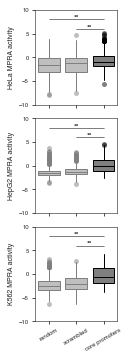

In [34]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(1.78, 5))
neg_control_plot(pool1_hela_elem_norm, order, palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_k562_elem_norm, order, palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
f.savefig("Fig_1C_S4A.pdf", bbox_inches="tight", dpi="figure")

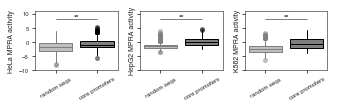

In [64]:
talk_order = ["RANDOM", "WILDTYPE"]
talk_palette = {"RANDOM": "gray", "WILDTYPE": "black"}

f, axarr = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(4.7, 1.5))
neg_control_plot(pool1_hela_elem_norm, talk_order, talk_palette, fontsize, "HeLa", axarr[0], None, "HeLa MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_hepg2_elem_norm, talk_order, talk_palette, fontsize, "HepG2", axarr[1], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool1_k562_elem_norm, talk_order, talk_palette, fontsize, "K562", axarr[2], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
plt.ylim((-10, 11))
f.savefig("neg_ctrl_boxplots.for_talk.pdf", bbox_inches="tight", dpi="figure")

### pool 2

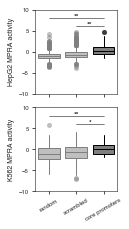

In [36]:
f, axarr = plt.subplots(2, sharex=True, sharey=True, figsize=(1.78, 3.2))
neg_control_plot(pool2_hepg2_elem_norm, order, palette, fontsize, "HepG2", axarr[0], None, "HepG2 MPRA activity", 
                 True, False, False, None)
neg_control_plot(pool2_k562_elem_norm, order, palette, fontsize, "K562", axarr[1], None, "K562 MPRA activity", 
                 True, False, False, None)
plt.tight_layout()
f.savefig("Fig_S8.pdf", bbox_inches="tight", dpi="figure")

## 5. boxplots: across TSS classes

the rest of the analysis only uses pool 1 (the TSS pool), as it looks at patterns in expression differences between TSS classes

In [37]:
pool1_hepg2_df = pool1_hepg2_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hela_df = pool1_hela_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_k562_df = pool1_k562_elem_norm.merge(annot, left_on="unique_id", right_on="seqID", how="left")
pool1_hepg2_df.head()

,unique_id,element,rna_3,rna_4,rna_5,rna_6,rna_7,rna_8,rna_9,rna_10,...,rna_14_padj,combined_padj,combined_sig,combined_class,downsamp_combined_sig,downsamp_combined_class,overall_mean,overall_median,seqID,PromType2
0,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,TGGCCAATCTACTCCCAGGAGCAGGGAGGGCAGGAGCCAGGGCTGG...,-0.974810,-0.987187,-0.980356,-1.028859,-1.070716,-1.183360,-1.290693,-1.002653,...,1.000000e+00,3.821744e-15,sig,not sig,sig,not sig,-1.108018,-1.104777,CONTROL_BUT_HAS_SNP__control.flip.sense__chr11...,protein_coding
1,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,CACCCCCATCCCAGGCTGAGTCACTCTAAGAAAAGGACAGTGTGGG...,-0.232201,-0.367854,-0.141330,-0.271426,-0.158697,-0.360512,-0.454494,-0.600754,...,1.101015e-16,4.445995e-190,sig,sig active,sig,sig active,-0.299548,-0.267746,CONTROL_BUT_HAS_SNP__control.flip.sense__chr16...,control
2,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,GCCTCGCCCTATGAGAAGGGGGCGGAGGCTGTGCCTGCCTTTGTGG...,-0.723533,-0.698930,-0.682626,-0.734014,-0.632885,-0.503992,-0.800393,-0.563289,...,2.045311e-07,2.778543e-105,sig,sig active,sig,sig active,-0.647109,-0.657756,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
3,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,CTGACCTATGTGCTTCTTCACTGGCCTTCTTGAGGGAGGGTGGGCG...,-1.033424,-0.942625,-1.413566,-1.064363,-1.247515,-1.273615,-1.021660,-1.224471,...,1.000000e+00,3.166269e-06,sig,not sig,not sig,not sig,-1.166325,-1.144993,CONTROL_BUT_HAS_SNP__control.flip.sense__chr17...,control
4,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,AGTATCCGCTCTCCCCTGTCCCCTGCTATGGGCAGGGCCTGGCTGG...,0.196014,0.263169,0.265157,0.136353,0.146875,0.188086,0.042627,0.209762,...,2.474752e-28,0.000000e+00,sig,sig active,sig,sig active,0.184302,0.187157,CONTROL_BUT_HAS_SNP__control.flip.sense__chr1:...,protein_coding


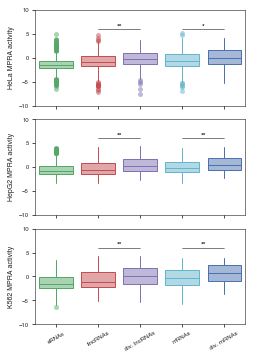

In [38]:
f, axarr = plt.subplots(3, sharex=True, sharey=True, figsize=(3.56, 5))
promtype_plot(pool1_hela_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "HeLa", axarr[0], None, 
              "HeLa MPRA activity", True, False, False, None)
promtype_plot(pool1_hepg2_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "HepG2", axarr[1], None, 
              "HepG2 MPRA activity", True, False, False, None)
promtype_plot(pool1_k562_df, TSS_CLASS_ORDER, TSS_CLASS_PALETTE, fontsize, "K562", axarr[2], None, 
              "K562 MPRA activity", True, False, False, None)
plt.tight_layout()
f.savefig("Fig_1D_S4B.pdf", bbox_inches="tight", dpi="figure")

## 6. barplots: find % of sequences active across cell types

In [39]:
pool1_hela_df["cell"] = "HeLa"
pool1_hepg2_df["cell"] = "HepG2"
pool1_k562_df["cell"] = "K562"

all_df = pool1_hela_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]].append(pool1_hepg2_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]]).append(pool1_k562_df[["unique_id", "better_type", "cell", "PromType2", "combined_class", "overall_mean"]])

In [40]:
df = all_df[all_df["better_type"] == "WILDTYPE"]
activ_grp = df.groupby("unique_id")["cell", "combined_class"].agg(lambda x: list(x)).reset_index()
activ_grp = activ_grp.merge(annot, left_on="unique_id", right_on="seqID", how="left").drop("seqID", axis=1)
activ_grp = activ_grp[(activ_grp["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(activ_grp["unique_id"].str.contains("SCRAMBLED"))]
activ_grp.sample(10)

,unique_id,cell,combined_class,PromType2
1865,WILDTYPE__Lincrna.noflip.NA__chr7:131582325..1...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",intergenic
1701,WILDTYPE__Lincrna.noflip.NA__chr11:568382..568...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",intergenic
392,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr9...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",Enhancer
1316,WILDTYPE__Enhancer.flip.sense__chr17:25821695....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
1451,WILDTYPE__Enhancer.noflip.NA__chr16:81515207.....,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer
1497,WILDTYPE__Enhancer.noflip.NA__chr1:36866671..3...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",Enhancer
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",div_lnc
1942,WILDTYPE__mrna.flip.sense__chr15:91478435..914...,"[HeLa, HepG2, K562]","[sig active, sig active, sig active]",protein_coding
618,WILDTYPE_BUT_HAS_SNP__mrna.flip.sense__chr6:13...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",div_pc
727,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr16:25...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding


In [41]:
activ_grp["active_in_only_one"] = activ_grp.apply(active_in_only_one, axis=1)
activ_grp["active_in_only_two"] = activ_grp.apply(active_in_only_two, axis=1)
activ_grp["active_in_only_three"] = activ_grp.apply(active_in_only_three, axis=1)
activ_grp.sample(5)

,unique_id,cell,combined_class,PromType2,active_in_only_one,active_in_only_two,active_in_only_three
1570,WILDTYPE__Enhancer.noflip.NA__chr5:55654942..5...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer,False,False,False
2046,WILDTYPE__mrna.noflip.NA__chr11:695736..695850...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",protein_coding,False,False,False
1574,WILDTYPE__Enhancer.noflip.NA__chr6:10403975..1...,"[HeLa, HepG2, K562]","[not sig, sig active, not sig]",Enhancer,True,False,False
1860,WILDTYPE__Lincrna.noflip.NA__chr7:104653459..1...,"[HeLa, HepG2, K562]","[not sig, sig active, sig active]",intergenic,False,True,False
1583,WILDTYPE__Enhancer.noflip.NA__chr6:30840570..3...,"[HeLa, HepG2, K562]","[not sig, not sig, not sig]",Enhancer,False,False,False


In [42]:
activ_counts_1 = activ_grp.groupby(["PromType2", "active_in_only_one"])["unique_id"].agg("count").reset_index()
activ_pcts_1 = activ_counts_1.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_1["percent"] = activ_pcts_1

activ_counts_2 = activ_grp.groupby(["PromType2", "active_in_only_two"])["unique_id"].agg("count").reset_index()
activ_pcts_2 = activ_counts_2.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_2["percent"] = activ_pcts_2

activ_counts_3 = activ_grp.groupby(["PromType2", "active_in_only_three"])["unique_id"].agg("count").reset_index()
activ_pcts_3 = activ_counts_3.groupby("PromType2")["unique_id"].apply(lambda x: 100 * x / float(x.sum()))
activ_counts_3["percent"] = activ_pcts_3

activ_counts_1 = activ_counts_1[activ_counts_1["active_in_only_one"]]
activ_counts_2 = activ_counts_2[activ_counts_2["active_in_only_two"]]
activ_counts_3 = activ_counts_3[activ_counts_3["active_in_only_three"]]

activ_counts = activ_counts_1.merge(activ_counts_2, on="PromType2").merge(activ_counts_3, on="PromType2")
activ_counts.drop(["active_in_only_one", "unique_id_x", "active_in_only_two", "unique_id_y", 
                   "active_in_only_three", "unique_id"],
                  axis=1, inplace=True)
activ_counts.columns = ["PromType2", "active_in_only_one", "active_in_only_two", "active_in_only_three"]
activ_counts = pd.melt(activ_counts, id_vars="PromType2")
activ_counts.head()

,PromType2,variable,value
0,Enhancer,active_in_only_one,25.886525
1,div_lnc,active_in_only_one,16.997167
2,div_pc,active_in_only_one,7.299270
3,intergenic,active_in_only_one,18.352941
4,protein_coding,active_in_only_one,16.193656


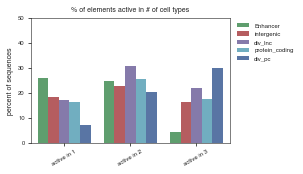

In [43]:
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3.56, 2.3))
ax = sns.barplot(data=df, x="variable", y="value", hue="PromType2", ci=None, palette=TSS_CLASS_PALETTE)
ax.set_xticklabels(["active in 1", "active in 2", "active in 3"], rotation=30)

plt.legend(bbox_to_anchor=(1.35, 1))
plt.ylim((0, 50))
plt.ylabel("percent of sequences", size=fontsize)
plt.xlabel("")
plt.title("% of elements active in # of cell types")

In [44]:
colors = []
for c in TSS_CLASS_ORDER:
    colors.append(TSS_CLASS_PALETTE[c])
colors

[(0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.6980392156862745),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451),
 (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)]

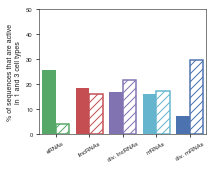

In [45]:
# better plot showing tissue sp
df = activ_counts[activ_counts["PromType2"] != "antisense"]
df["PromType2"] = pd.Categorical(df["PromType2"], TSS_CLASS_ORDER)
df.sort_values(by="PromType2")

plt.figure(figsize=(3,2.3))
ax = sns.barplot(data=df[df["variable"]!="active_in_only_two"], x="PromType2", y="value", 
                 ci=None, hue="variable", linewidth=1.5)
ax.set_xticklabels(["eRNAs", "lincRNAs", "div. lncRNAs", "mRNAs", "div. mRNAs"], rotation=30)

colors = colors*2
for i, p in enumerate(ax.patches):
    if i < 5:
        p.set_facecolor(colors[i])
    else:
        p.set_facecolor("white")
        p.set_edgecolor(colors[i])
        p.set_alpha(1)
        p.set_hatch("///")

ax.legend().set_visible(False)
plt.ylim((0, 50))
plt.ylabel("% of sequences that are active\nin 1 and 3 cell types", fontsize=fontsize)
plt.xlabel("")
plt.savefig("Fig_1F.pdf", bbox_inches="tight", dpi="figure")

## 7. kdeplot: compare to CAGE

In [46]:
hepg2_activ = pool1_hepg2_df[["unique_id", "element", "better_type", "overall_mean", "PromType2"]]
hela_activ = pool1_hela_df[["unique_id", "element", "better_type", "overall_mean"]]
k562_activ = pool1_k562_df[["unique_id", "element", "better_type", "overall_mean"]]

all_activ = hepg2_activ.merge(hela_activ, on=["unique_id", "element", "better_type"], how="left").merge(k562_activ, on=["unique_id", "element", "better_type"], how="left")
all_activ.columns = ["unique_id", "element", "better_type", "HepG2", "PromType2", "HeLa", "K562"]
all_activ = all_activ[["unique_id", "element", "better_type", "PromType2", "HepG2", "HeLa", "K562"]]
all_activ = all_activ[(all_activ["PromType2"].isin(TSS_CLASS_ORDER)) & 
                      ~(all_activ["unique_id"].str.contains("SCRAMBLED")) &
                      (all_activ["better_type"] == "WILDTYPE")]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562
3904,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr17:20...,CAGATGAGGGGGCGGGGCCCACGGGCGCGGGAGAGCAGCGGCTCCG...,WILDTYPE,div_pc,-0.499355,0.257016,0.235142
6867,WILDTYPE__mrna.flip.sense__chr14:95623831..956...,CCTGTCCAATCACAGGCTCGCTCTCATGCCGCCACGGGGCGAGCGG...,WILDTYPE,div_pc,-1.291150,-3.149145,-2.049599
6719,WILDTYPE__Lincrna.noflip.NA__chr2:105050738..1...,GGAGTCCAGGGTTTTTGTCACACACACACACAGCACAGATTTTTTT...,WILDTYPE,intergenic,-1.989735,-2.100721,-2.143888
3309,WILDTYPE_BUT_HAS_SNP__Antisense.noflip.NA__chr...,GCCCAGCCCCACGCAGCGGGGACCTGCCCTTTCTCTCAGCCTTCCT...,WILDTYPE,div_lnc,1.351035,0.167886,1.346352
6701,WILDTYPE__Lincrna.noflip.NA__chr20:48883955..4...,ATGACAGCCCTGTGAGGTCCCGTCATCCCATTTAACCAACAAGGAA...,WILDTYPE,intergenic,-0.947968,-1.355711,-1.781596


In [47]:
all_activ["combined_class"] = ""
all_activ = all_activ.merge(pool1_hela_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HeLa")).merge(pool1_hepg2_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_HepG2")).merge(pool1_k562_elem_norm[["unique_id", "element", "combined_class"]], on=["unique_id", "element"], how="left", suffixes=("", "_K562"))
all_activ.drop("combined_class", axis=1, inplace=True)
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active


In [48]:
all_activ["oligo_reg"] = all_activ.unique_id.str.split("__", expand=True)[2]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg
1321,WILDTYPE__Enhancer.noflip.NA__chr17:7746046..7...,CTGATTCAGGCTTGGGGTGGGGGAGCGTGAGTCACCCAGAAAACCT...,WILDTYPE,Enhancer,2.368330,-0.545688,1.258440,not sig,sig active,sig active,"chr17:7746046..7746160,-"
1609,WILDTYPE__Lincrna.noflip.NA__chr1:235116488..2...,TGAGTGTCTGCTTCCTCTCTGACTCAGGATTGGATCTGTTTCTGAG...,WILDTYPE,intergenic,-1.363238,-0.714371,-2.854139,not sig,not sig,not sig,"chr1:235116488..235116602,-"
1127,WILDTYPE__Antisense.noflip.NA__chr7:27135709.....,TGCAAAAGTTTGCCGGCTTCCGCAGTGATGGATCACCGTTTTAGTG...,WILDTYPE,div_lnc,-1.257703,-4.237653,-3.257348,not sig,not sig,not sig,"chr7:27135709..27135823,+"
220,WILDTYPE_BUT_HAS_SNP__Enhancer.noflip.NA__chr1...,GAAATTTCTGCATAAACTGCCCCTTAATCTGCATGTAATTAAAAGT...,WILDTYPE,Enhancer,-1.262833,-0.883879,-2.320534,not sig,not sig,not sig,"chr16:75410781..75410895,+"
1164,WILDTYPE__Enhancer.flip.sense__chr14:71865867....,TGATGCATATTCAAGTCCTGTTTCAGCTGTGAACTTCTGCTTTTCA...,WILDTYPE,Enhancer,-1.670421,-1.474100,-2.740249,not sig,not sig,not sig,"chr14:71865867..71865981,+"


In [49]:
id_map = id_map[["oligo_reg", "K562_rep1", "K562_rep2", "K562_rep3", "HeLa_rep1", "HeLa_rep2", "HeLa_rep3", 
                 "HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]]
all_activ = all_activ.merge(id_map, on="oligo_reg")
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,oligo_reg,K562_rep1,K562_rep2,K562_rep3,HeLa_rep1,HeLa_rep2,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3
375,WILDTYPE_BUT_HAS_SNP__Lincrna.flip.sense__chr5...,TCAGAGCCCACCCATGGACCAATCAGCATGCACGTCCTTCATTCTG...,WILDTYPE,intergenic,1.243556,-1.328749,0.757962,not sig,sig active,sig active,"chr5:104728636..104728750,-",31.357797,31.370005,34.067782,0.000000,0.000000,0.000000,5.199690,5.109783,5.392284
148,WILDTYPE_BUT_HAS_SNP__Enhancer.flip.sense__chr...,CGCTTCCATGCGCAACTTGGGCTCCGCCTCCTGCCCCTCCCCTATC...,WILDTYPE,Enhancer,-0.409297,0.026676,-0.859898,not sig,sig active,sig active,"chr1:209601309..209601423,-",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
874,WILDTYPE_BUT_HAS_SNP__mrna.noflip.NA__chr6:261...,GTGGTTCCCGCCCCTTCTCATGAGGTTTTCAAACAGGTCCGTCATG...,WILDTYPE,protein_coding,1.582675,-1.696076,-0.848918,not sig,sig active,sig active,"chr6:26189305..26189419,-",162.880067,148.027213,111.601355,78.759654,114.457871,77.516991,540.058715,508.341014,500.538717
1735,WILDTYPE__Lincrna.noflip.NA__chr8:37351349..37...,GAGATTTATTCATTCTGACTCAAGCTTAGCTCACAATTATACAGCA...,WILDTYPE,intergenic,-1.264947,-0.078693,-2.936829,not sig,not sig,not sig,"chr8:37351349..37351463,-",0.000000,0.000000,0.000000,0.096756,0.000000,0.000000,0.000000,0.000000,0.000000
1960,WILDTYPE__mrna.noflip.NA__chr19:4007669..40077...,GCCCGGGCGGCGGCCCCGCCCGCGAGTGGTGAGCGGTCACGTGACG...,WILDTYPE,protein_coding,NaN,NaN,NaN,not sig,not sig,not sig,"chr19:4007669..4007783,+",12.407761,14.312565,12.922262,16.158307,17.614525,14.945013,21.901725,21.840202,22.377977


In [50]:
all_activ["K562_av"] = all_activ[["K562_rep1", "K562_rep2", "K562_rep3"]].mean(axis=1)
all_activ["HeLa_av"] = all_activ[["HeLa_rep1", "HeLa_rep2", "HeLa_rep3"]].mean(axis=1)
all_activ["HepG2_av"] = all_activ[["HepG2_rep1", "HepG2_rep2", "HepG2_rep3"]].mean(axis=1)

all_activ["K562_log_av"] = np.log(all_activ["K562_av"]+1)
all_activ["HeLa_log_av"] = np.log(all_activ["HeLa_av"]+1)
all_activ["HepG2_log_av"] = np.log(all_activ["HepG2_av"]+1)

In [51]:
all_activ = all_activ[(~all_activ["unique_id"].str.contains("SNP_INDIV")) & 
                      (~all_activ["unique_id"].str.contains("SNP_PLUS_HAPLO")) & 
                      (~all_activ["unique_id"].str.contains("FLIPPED"))]
all_activ.sample(5)

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,HeLa_rep3,HepG2_rep1,HepG2_rep2,HepG2_rep3,K562_av,HeLa_av,HepG2_av,K562_log_av,HeLa_log_av,HepG2_log_av
1614,WILDTYPE__Lincrna.noflip.NA__chr1:43824309..43...,CGGCCGGGACAGGGCGGGGCAGGGCGGGGCCGGGTGGGGCCTGCGC...,WILDTYPE,div_lnc,-0.773202,-1.507354,-0.144212,not sig,not sig,not sig,...,1.642309,0.236350,0.247248,0.404421,0.887579,2.093913,0.296006,0.635295,1.129437,0.259287
1314,WILDTYPE__Enhancer.noflip.NA__chr17:46102468.....,CCTGCTGACTAACTCCGCCCCCAGGGCGGACCCGACTCCGGCTCCT...,WILDTYPE,Enhancer,-0.248247,-0.156370,0.052674,not sig,sig active,not sig,...,0.629186,0.000000,0.000000,0.000000,0.000000,0.799902,0.000000,0.000000,0.587732,0.000000
1578,WILDTYPE__Lincrna.noflip.NA__chr14:106938369.....,CGCCGACGTCCCGCCATCCCCCGCGCGTCCCCGGACCGCCCACGTC...,WILDTYPE,intergenic,1.922151,1.093622,2.083049,not sig,not sig,not sig,...,0.000000,0.000000,0.000000,0.000000,1.300254,0.000000,0.000000,0.833020,0.000000,0.000000
1886,WILDTYPE__mrna.noflip.NA__chr10:72201402..7220...,TTCCCCAGAGGGAGGAAAGGTGGGGGCGGGGCGGCTGCTGAGGCCC...,WILDTYPE,protein_coding,0.125056,-2.114666,-1.612601,not sig,sig active,not sig,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1731,WILDTYPE__Lincrna.noflip.NA__chr8:125486770..1...,TTGCCATGGTTTCCGCCCACCTCCTCAGCTTACTCTAGCTTCGTGC...,WILDTYPE,div_lnc,0.503284,-0.680421,0.967414,not sig,sig active,sig active,...,4.680581,1.418097,2.225228,2.359124,12.234499,6.115862,2.000816,2.582827,1.962326,1.098884


In [52]:
# first scale mpra ranges to be positive
all_activ["hepg2_scaled"] = scale_range(all_activ["HepG2"], 0, 100)
all_activ["hela_scaled"] = scale_range(all_activ["HeLa"], 0, 100)
all_activ["k562_scaled"] = scale_range(all_activ["K562"], 0, 100)

In [53]:
cage_ts = calculate_tissue_specificity(all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]])
all_activ["cage_activ"] = all_activ[["HepG2_log_av", "K562_log_av", "HeLa_log_av"]].mean(axis=1)
all_activ["cage_ts"] = cage_ts

mpra_ts = calculate_tissue_specificity(all_activ[["hepg2_scaled", "k562_scaled", "hela_scaled"]])
all_activ["mpra_activ"] = all_activ[["HepG2", "K562", "HeLa"]].mean(axis=1)
all_activ["mpra_ts"] = mpra_ts
all_activ.head()

,unique_id,element,better_type,PromType2,HepG2,HeLa,K562,combined_class_HeLa,combined_class_HepG2,combined_class_K562,...,K562_log_av,HeLa_log_av,HepG2_log_av,hepg2_scaled,hela_scaled,k562_scaled,cage_activ,cage_ts,mpra_activ,mpra_ts
0,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GGTGGGCCCCCTCCCCCTTCTTCCGGCGGGCCTCCTCCCTCCCCTT...,WILDTYPE,intergenic,2.688943,-0.470427,1.981653,sig active,sig active,sig active,...,5.406185,0.000000,0.025922,76.188273,47.913344,71.954421,1.810702,0.665068,1.400056,0.142230
1,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,GACTAAATAAGGGAGGCTGCAGCGGCTGCGCGTGCGCCCAGAGGCG...,WILDTYPE,div_lnc,-0.701841,0.371693,0.166442,not sig,sig active,not sig,...,0.684124,0.900545,1.024832,26.698185,55.709983,48.891741,0.869834,0.151243,-0.054568,0.214384
2,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AACTCGCCCTCCGGAAAGACGCGGGGGAATTCTGGGAGTGCGCGGC...,WILDTYPE,intergenic,1.704007,0.456156,1.976386,sig active,sig active,sig active,...,2.740342,2.511808,3.443071,61.812671,56.491967,71.887500,2.898407,0.158191,1.378850,0.118103
3,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,CACCAACCGCCCCACCGCACCCTGCGCCAGCCCTACGGCGCCCGCG...,WILDTYPE,intergenic,-0.022075,1.114820,-0.701002,not sig,sig active,not sig,...,2.012675,2.514709,1.958286,36.619685,62.590112,37.870653,2.161890,0.140302,0.130581,0.269957
4,WILDTYPE_BUT_HAS_SNP__Antisense.flip.sense__ch...,AGACCCACAGGAAATGACGACAGAAGGGCTGAGGTGGGGGGGCGGG...,WILDTYPE,div_lnc,3.759629,2.141635,3.237685,sig active,sig active,sig active,...,1.126949,1.512361,0.572818,91.815440,72.096713,87.912612,1.070710,0.292028,3.046316,0.085757


In [54]:
cmap = sns.light_palette("darkslategray", as_cmap=True)

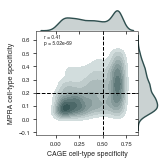

In [55]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.ax_joint.axhline(y=0.2, color="black", linewidth=1, linestyle="dashed")
g.ax_joint.axvline(x=0.5, color="black", linewidth=1, linestyle="dashed")
g.set_axis_labels("CAGE cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("Fig_1E.pdf", bbox_inches="tight", dpi="figure")

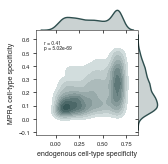

In [65]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_ts"])) & (~pd.isnull(all_activ["cage_ts"]))]
g = sns.jointplot(data=no_nan, x="cage_ts", y="mpra_ts", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, cmap=cmap, color="darkslategrey")
g.set_axis_labels("endogenous cell-type specificity", "MPRA cell-type specificity")
r, p = stats.spearmanr(no_nan["cage_ts"], no_nan["mpra_ts"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .75), xycoords=ax.transAxes, 
                    fontsize=5)
g.savefig("cage_mpra_corr.for_talk.pdf", bbox_inches="tight", dpi="figure")

In [56]:
def cage_v_mpra_ts(row):
    if row["cage_ts"] > 0.5 and row["mpra_ts"] > 0.2:
        return "ts in both"
    elif row["cage_ts"] > 0.5 and row["mpra_ts"] <= 0.2:
        return "ts in cage, not mpra"
    elif row["cage_ts"] <= 0.5 and row["mpra_ts"] > 0.2:
        return "ts in mpra, not cage"
    else:
        return "not ts in both"
    
no_nan["ts_status"] = no_nan.apply(cage_v_mpra_ts, axis=1)
no_nan.ts_status.value_counts()

not ts in both          692
ts in both              402
ts in mpra, not cage    310
ts in cage, not mpra    236
Name: ts_status, dtype: int64

In [57]:
tot = 692+402+310+236
upper_left = 310
upper_right = 402
lower_left = 692
lower_right = 236
print("upper left: %s" % (upper_left/tot))
print("upper right: %s" % (upper_right/tot))
print("lower left: %s" % (lower_left/tot))
print("lower right: %s" % (lower_right/tot))

upper left: 0.18902439024390244
upper right: 0.2451219512195122
lower left: 0.4219512195121951
lower right: 0.14390243902439023


In [58]:
(692+402)/(692+402+310+236)

0.6670731707317074

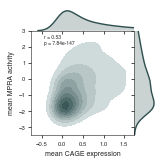

In [59]:
no_nan = all_activ[(~pd.isnull(all_activ["mpra_activ"])) & (~pd.isnull(all_activ["cage_activ"]))]
g = sns.jointplot(data=no_nan, x="cage_activ", y="mpra_activ", kind="kde", shade_lowest=False, size=2.3, space=0,
                  stat_func=None, xlim=(-0.75, 1.75), ylim=(-3.5, 3), cmap=cmap, color="darkslategray")
g.set_axis_labels("mean CAGE expression", "mean MPRA activity")
r, p = stats.spearmanr(no_nan["cage_activ"], no_nan["mpra_activ"])
g.ax_joint.annotate("r = {:.2f}\np = {:.2e}".format(r, Decimal(p)), xy=(.1, .8), xycoords=ax.transAxes, 
                    fontsize=5)

In [60]:
# write file with tissue-specificities for later use
final = all_activ[["unique_id", "PromType2", "cage_activ", "cage_ts", "mpra_activ", "mpra_ts"]]
final.to_csv("../../data/02__activs/POOL1__pMPRA1__CAGE_vs_MPRA_activs.txt", sep="\t", index=False)